<a href="https://colab.research.google.com/github/AbdulmalikGiwa/LogisticsBusinessAnalysis/blob/master/LogisticsBusiness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone project - Logistics business

## Table of contents

*   [Background/Problem Description](#introduction)
*   [Data Section](#data)
*   [Methodology](#methodology)

*   [Conclusion](conclusion)



##Background/Problem Description <a name="introduction"></a>

A logistics company focused on meal delivery from restaurants within a location is looking to expand to Canada and plans on starting the expansion with a few neighborhoods in Toronto, the company's main business model/strategy is setting up small outlets in neighborhoods and providing delivery services for restaurants within that neighborhood. The company needs to get an insight and understand the individual prospect of each neighborhood within a region in order to know which of these neighborhoods would be the best fit for their business as regards the types of outlets within each neighborhood and the potential demand for the type of service that is offered by the company. The main question to be answered is : 


*   Which neighborhood has the highest density of restaurants hence the best fit for such business?



## Data Section <a name="data"></a>
This is a breakdown of the data to be used in this analysis and how the data would be used. Foursquare API is a location data provider and can be used to get data on every venue/outlet within a given geolocation and the category to which the venue belongs to. The location in question for this analysis is Toronto which is the provincial capital of Ontario and the most populous city in canada. The following is a more detailed explanation:





*   Neighborhoods in Toronto: A list of every neighborhood in Toronto will be obtained, either by scraping a wikipedia page or from the google dataset search.
*   Neighborhood geographic coordinate: A list of the corresponding longitude and latitude values of each neighborhood
*   Venues: The Foursquare API returns a list of venues within a specified radius of a given location( All neighborhoods in Toronto,Ontario in this case). A data column on every venue within 500m of each neighborhood is obtained
*   Venues Category: The category for each venue returned is also returned from the Foursquare API.

The following section here consists of importing all the necessary libraries and dataset needed for the analysis

In [0]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

After importing all necesary libraries I'll move on to collecting the required dataset, from a wikipedia page

In [2]:
#Using BeautifulSoup,pandas and requests to read a table from the web into a dataframe
Table_source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
Bs = BeautifulSoup(Table_source, 'lxml')
Table = Bs.find('table')
df = pd.read_html(str(Table))[0]
df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [3]:
#using an existing dataset consisting of latitude and longitude values for each postal code
!wget -q -O 'lat_lng.csv'  https://cocl.us/Geospatial_data
lat_lng = pd.read_csv('lat_lng.csv')
lat_lng.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


###Data Cleaning

There were a few missing values in the dataset scraped online, values were missing in a few rows in the neighborhood and borough columns together, these rows were dropped. Furthermore, the dataframes are merged to create a new column for the latitude and longitude values for each postal code

In [4]:
#Dropping rows without an assigned value for the borough column
drop_condition = df.loc[df['Borough']=='Not assigned']
df.drop(drop_condition.index, axis=0, inplace=True)
df = df.reset_index(drop= True)

df.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [5]:
df.isna().sum()

Postal Code     0
Borough         0
Neighborhood    0
dtype: int64

In [6]:
#Merging corresponding values in lat_lng with df
lat_map = lat_lng.set_index('Postal Code')['Latitude'].to_dict()
lng_map = lat_lng.set_index('Postal Code')['Longitude'].to_dict()
df['Latitude'] = df['Postal Code'].map(lat_map)
df['Longitude'] = df['Postal Code'].map(lng_map)
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [7]:
df2 = df.loc[df['Borough'].str.contains('Toronto')]
df2 = df2.reset_index(drop=True)
df2.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


##Methodology <a name="methodology"></a>

The Foursquare API was used in getting all the venues around each postal code and the category each venue belongs to. The request made to the Foursquare API wasn’t straightforward since the API returns a json file comprising of other features asides the required ones, a few tweaks were made to filter the results from the request leaving only the needed features in merged with other existing features to form a new dataframe.

In [8]:
# This is to get the latitide and longitude values of toronta
from geopy.geocoders import Nominatim
address= 'Toronto, Ontario'
geolocator = Nominatim(user_agent='toronto_explorer')
Location = geolocator.geocode(address)
Latitude = Location.latitude
Longitude= Location.longitude 
print('The coordinates of toronto are {},{}'.format(Latitude,Longitude))

The coordinates of toronto are 43.6534817,-79.3839347


In [9]:
import folium
Neighborhoods_map = folium.Map(location=[Latitude,Longitude], zoom_start=11)
for  neigh_lat, neigh_lng, neigh_name in zip(df2['Latitude'],df2['Longitude'],df2['Neighborhood']) :
  Label = folium.Popup(neigh_name, parse_html=True)
  folium.CircleMarker([neigh_lat,neigh_lng],
                radius=4,
                popup=Label,
                color='blue',
                fill=True,
                fill_color='#3186cc',
                fill_opacity=0.7).add_to(Neighborhoods_map)

Neighborhoods_map

In [10]:
import folium
Neighborhoods_map_total = folium.Map(location=[Latitude,Longitude], zoom_start=11)
for  allneigh_lat, allneigh_lng, allneigh_name in zip(df['Latitude'],df['Longitude'],df['Neighborhood']) :
  Label = folium.Popup(allneigh_name, parse_html=True)
  folium.CircleMarker([allneigh_lat,allneigh_lng],
                radius=4,
                popup=Label,
                color='blue',
                fill=True,
                fill_color='#3186cc',
                fill_opacity=0.7).add_to(Neighborhoods_map_total)

Neighborhoods_map_total

In [0]:
#API credentials
CLIENT_ID = 'NTXIJ3HWNEVHIVHIWFVKN1ODFIGJUOYC3ZNQRKFFQM5NJKLU' # Foursquare ID
CLIENT_SECRET = 'JNBOIMLHNUYZMYEHABL1UNGWORK0QZNLPR2AG3B24UGG1EB5' # Foursquare Secret
VERSION = '20180605'
RADIUS = 500
LIMIT= 70

In [0]:
#Function to query the foursquare api and return venues within 500m radius of each postal code and their category
def getNearbyVenues(names, latitudes, longitudes, radius=500) :

  venues_list = []
  for name,lat,lng in zip(names,latitudes,longitudes) :
    #print(name)
    url= 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID,
                                                                                                                              CLIENT_SECRET,
                                                                                                                              VERSION,
                                                                                                                              lat,
                                                                                                                              lng,
                                                                                                                              radius,
                                                                                                                              LIMIT)
    
    results= requests.get(url).json()["response"]['groups'][0]['items']
    venues_list.append([(name,
                         lat,
                         lng,
                         v['venue']['name'],
                         v['venue']['location']['lat'],
                         v['venue']['location']['lng'],
                         v['venue']['categories'][0]['name']) for v in results])
    nearby_venues= pd.DataFrame([Item for venue_list in venues_list for Item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

                  
  return(nearby_venues)

In [13]:
toronto_venues= getNearbyVenues(df['Neighborhood'],
                                df['Latitude'],
                                df['Longitude'])
toronto_venues.shape

(1908, 7)

In [14]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [0]:

tor= toronto_venues[['Neighborhood','Venue Category']]


In [17]:
for i in tor['Venue Category'] :
  if 'Restaurant' in i :
    tor['Venue Category'].replace({i:'Restaurant'},inplace=True) 
tor.head()   

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,Neighborhood,Venue Category
0,Parkwoods,Park
1,Parkwoods,Food & Drink Shop
2,Victoria Village,Hockey Arena
3,Victoria Village,Coffee Shop
4,Victoria Village,Restaurant


In [18]:
tor['Venue Category'].value_counts()

Restaurant               431
Coffee Shop              146
Café                      97
Park                      50
Pizza Place               45
                        ... 
Golf Course                1
Market                     1
College Arts Building      1
Skate Park                 1
Church                     1
Name: Venue Category, Length: 219, dtype: int64

In [0]:
torr_hot = pd.get_dummies(tor[['Venue Category']], prefix="", prefix_sep="")
#torr_hot['Neighborhood'] = toronto_venues['Neighborhood']

In [0]:
#torr_hot= toronto_venues.loc[toronto_venues['Venue Category'].str.contains('Restaurant')]

In [25]:
tor_hot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
tor_hot['Neighborhood'] = toronto_venues['Neighborhood']
tor_hot.head()


,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,...,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
col_list_rest = list(torr_hot)
col_list = list(tor_hot)
col_list.remove('Neighborhood')

tor_hot['Total Restaurants'] = tor_hot[col_list_rest].sum(axis=1) 
tor_hot['Total Venues'] = tor_hot[col_list].sum(axis=1)

In [0]:
tor_hot.loc[tor_hot['Total Venues']==2]

In [27]:
tor_hot.drop(tor_hot.columns.difference(['Neighborhood', 'Total Venues', 'Total Restaurants']),1 , inplace=True)
tor_hot.head()

,Neighborhood,Total Restaurants,Total Venues
0,Parkwoods,1,1
1,Parkwoods,1,1
2,Victoria Village,1,1
3,Victoria Village,1,1
4,Victoria Village,0,1


In [28]:
Toronto_table= tor_hot.groupby('Neighborhood').sum().reset_index()
Toronto_table.head()

,Neighborhood,Total Restaurants,Total Venues
0,Agincourt,2,3
1,"Alderwood, Long Branch",8,8
2,"Bathurst Manor, Wilson Heights, Downsview North",18,20
3,Bayview Village,2,4
4,"Bedford Park, Lawrence Manor East",14,23


In [29]:
table_sorted_des = Toronto_table.sort_values('Total Venues', ascending=False)
table_sorted_des.head()

,Neighborhood,Total Restaurants,Total Venues
83,"Toronto Dominion Centre, Design Exchange",56,70
18,"Commerce Court, Victoria Hotel",56,70
75,Stn A PO Boxes,58,70
29,"First Canadian Place, Underground city",53,70
72,St. James Town,53,70


In [30]:
most_ven= Toronto_table.loc[Toronto_table['Total Venues']==70]
most_ven

,Neighborhood,Total Restaurants,Total Venues
15,Church and Wellesley,50,70
18,"Commerce Court, Victoria Hotel",56,70
29,"First Canadian Place, Underground city",53,70
31,"Garden District, Ryerson",52,70
72,St. James Town,53,70
75,Stn A PO Boxes,58,70
83,"Toronto Dominion Centre, Design Exchange",56,70


In [31]:
table_sorted_des = Toronto_table.sort_values('Total Restaurants', ascending=False)
table_sorted_des.head()

,Neighborhood,Total Restaurants,Total Venues
35,"Harbourfront East, Union Station, Toronto Islands",61,69
75,Stn A PO Boxes,58,70
28,"Fairview, Henry Farm, Oriole",57,67
18,"Commerce Court, Victoria Hotel",56,70
83,"Toronto Dominion Centre, Design Exchange",56,70


In [32]:
table_sorted_ven = Toronto_table.sort_values('Total Venues', ascending=False)
table_sorted_ven.head()

,Neighborhood,Total Restaurants,Total Venues
83,"Toronto Dominion Centre, Design Exchange",56,70
18,"Commerce Court, Victoria Hotel",56,70
75,Stn A PO Boxes,58,70
29,"First Canadian Place, Underground city",53,70
72,St. James Town,53,70


In [33]:
most_res = Toronto_table.loc[Toronto_table['Total Restaurants']>=53]
most_res= most_res.set_index(['Neighborhood'])
most_res.head()

,Total Restaurants,Total Venues
Neighborhood,,
"Commerce Court, Victoria Hotel",56,70
"Fairview, Henry Farm, Oriole",57,67
"First Canadian Place, Underground city",53,70
"Harbourfront East, Union Station, Toronto Islands",61,69
St. James Town,53,70


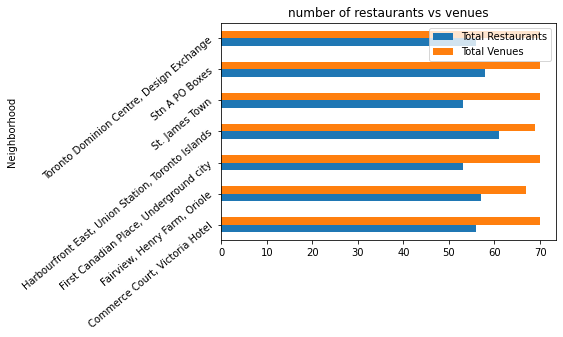

In [34]:
import matplotlib.pyplot as plot
most_res.plot.barh(rot=40, title="number of restaurants vs venues")
plot.show(block=True)

In [0]:
most_res =most_res.reset_index()

In [36]:
lat_res = toronto_venues.set_index('Neighborhood')['Neighborhood Latitude'].to_dict()
lng_res= toronto_venues.set_index('Neighborhood')['Neighborhood Longitude'].to_dict()
most_res['Latitude'] = most_res['Neighborhood'].map(lat_res)
most_res['Longitude'] = most_res['Neighborhood'].map(lng_res)

most_res.head()

,Neighborhood,Total Restaurants,Total Venues,Latitude,Longitude
0,"Commerce Court, Victoria Hotel",56,70,43.648198,-79.379817
1,"Fairview, Henry Farm, Oriole",57,67,43.778517,-79.346556
2,"First Canadian Place, Underground city",53,70,43.648429,-79.382280
3,"Harbourfront East, Union Station, Toronto Islands",61,69,43.640816,-79.381752
4,St. James Town,53,70,43.651494,-79.375418


In [37]:
res_map = folium.Map(location=[43.6534817,-79.3839347], zoom_start=11)
for lat, lng, name in zip(most_res['Latitude'], most_res['Longitude'], most_res['Neighborhood']):
  label = folium.Popup(name, parse_html=True)
  folium.CircleMarker([lat,lng],
                popup= label,
                radius=10,
                color='green').add_to(res_map)
                
res_map                

In [39]:
from sklearn.cluster import KMeans 
no_of_clusters = 3
res_val = Toronto_table[['Total Restaurants', 'Total Venues']].values
Toronto_clusters = KMeans(n_clusters= no_of_clusters, random_state=0).fit(res_val)
Toronto_clusters.labels_

array([2, 2, 0, 2, 0, 1, 2, 0, 0, 0, 2, 2, 2, 1, 0, 1, 2, 2, 1, 0, 2, 2,
       0, 2, 0, 0, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 0, 2, 2, 2, 2, 0, 2, 1,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 1, 1, 2,
       2, 2, 0, 2, 2, 2, 1, 0, 2, 1, 0, 0, 0, 2, 0, 2, 0, 1, 0, 2, 2, 2,
       2, 0, 2, 2, 2], dtype=int32)

In [0]:
Toronto_backup = Toronto_table

In [45]:
Toronto_table.insert(0, 'Cluster Labels', Toronto_clusters.labels_)
Toronto_table.head()

,Cluster Labels,Neighborhood,Total Restaurants,Total Venues
0,2,Agincourt,2,3
1,2,"Alderwood, Long Branch",8,8
2,0,"Bathurst Manor, Wilson Heights, Downsview North",18,20
3,2,Bayview Village,2,4
4,0,"Bedford Park, Lawrence Manor East",14,23


In [47]:
lat_res = toronto_venues.set_index('Neighborhood')['Neighborhood Latitude'].to_dict()
lng_res= toronto_venues.set_index('Neighborhood')['Neighborhood Longitude'].to_dict()
Toronto_table['Latitude'] = Toronto_table['Neighborhood'].map(lat_res)
Toronto_table['Longitude'] = Toronto_table['Neighborhood'].map(lng_res)

Toronto_table.head()

,Cluster Labels,Neighborhood,Total Restaurants,Total Venues,Latitude,Longitude
0,2,Agincourt,2,3,43.794200,-79.262029
1,2,"Alderwood, Long Branch",8,8,43.602414,-79.543484
2,0,"Bathurst Manor, Wilson Heights, Downsview North",18,20,43.754328,-79.442259
3,2,Bayview Village,2,4,43.786947,-79.385975
4,0,"Bedford Park, Lawrence Manor East",14,23,43.733283,-79.419750


In [49]:
import matplotlib.cm as cm
import matplotlib.colors as colors
cluster_map = folium.Map(location=[43.6534817,-79.3839347], zoom_start=11)

#setting the color schemes for clusters
x= np.arange(no_of_clusters)
ys = [i + x + (i*x)**2 for i in range(no_of_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lon, poi, cluster in zip(Toronto_table['Latitude'], Toronto_table['Longitude'], Toronto_table['Neighborhood'], Toronto_table['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(cluster_map)
       
cluster_map




In [50]:
most_res['Neighborhood']

0                       Commerce Court, Victoria Hotel
1                         Fairview, Henry Farm, Oriole
2               First Canadian Place, Underground city
3    Harbourfront East, Union Station, Toronto Islands
4                                       St. James Town
5                                       Stn A PO Boxes
6             Toronto Dominion Centre, Design Exchange
Name: Neighborhood, dtype: object